# DINOV2 WITH AND WITHOUT REGISTERS

In [12]:
# Copyright (c) Facebook, Inc. and its affiliates.
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Note the original is here: https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

import os
import sys
import argparse
import random
import colorsys
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
from dinov2.models.vision_transformer import vit_small, vit_large
from dinov2.models.vision_transformer import DinoVisionTransformer

## DINOV2 WITHOUT REGISTERS

In [ ]:
if __name__ == '__main__':
    image_size = (952, 952) 
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = vit_large(
            patch_size=14,
            img_size=526,
            init_values=1.0,
            block_chunks=0
    )

    model.load_state_dict(torch.load('dinov2_vitl14_pretrain.pth'))
    for p in model.parameters():
        p.requires_grad = False
    model.to(device)
    model.eval()

    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    print(img.shape)

    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    print(img.shape)

    attentions = model.get_last_self_attention(img.to(device))
    
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    # for every patch
    #attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    
    attentions = attentions[0, :, 0, :] 

    # weird: one pixel gets high attention over all heads?
    #attentions[:, 283] = 0 

    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()


torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])
Inside get_last_self_attention


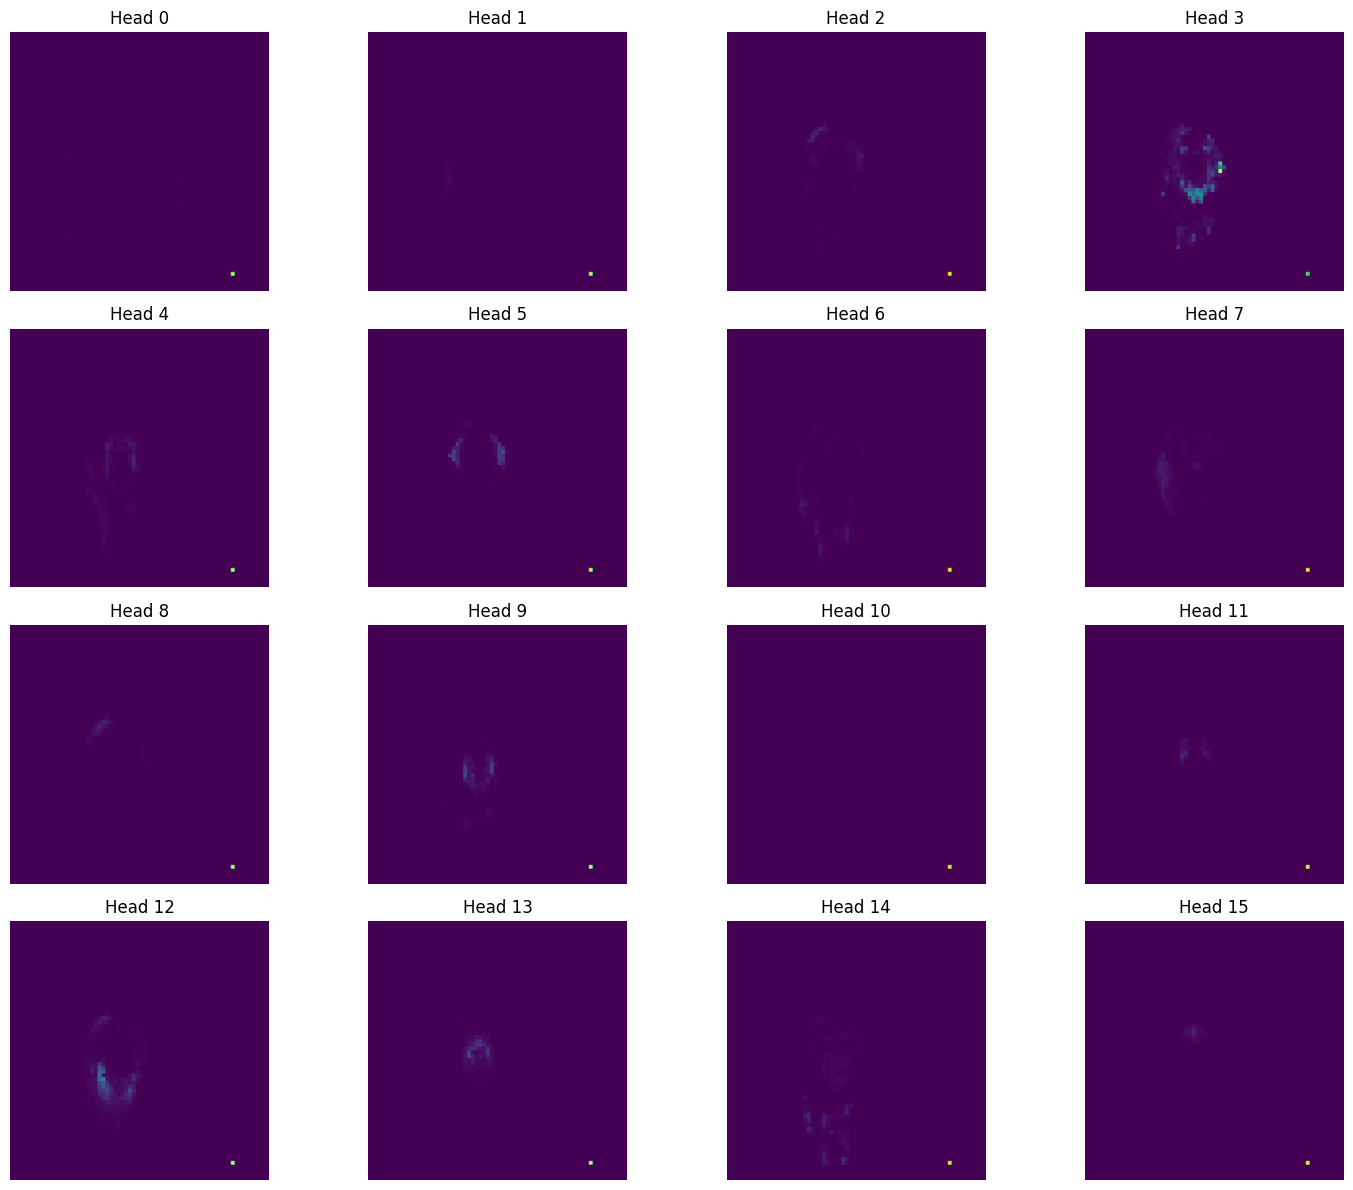

In [14]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Plot all attention maps
for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


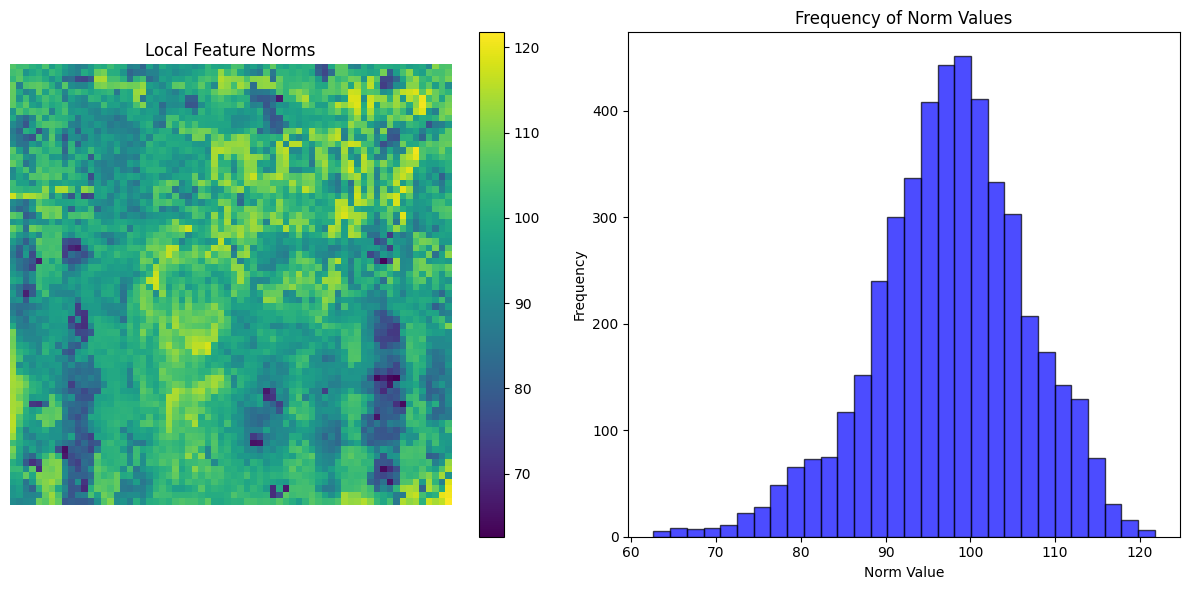

In [15]:
# DINOV2 NORMS WITHOUT REGISTERS

features = model.forward_features(img)["x_prenorm"]

patch_features = features[:, 1:, :]  
local_feature_norms = torch.norm(patch_features, dim=-1)  

w_featmap = h_featmap = int((img.shape[-1] // 14)) 
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## DINOV2 WITH REGISTERS

In [8]:
if __name__ == '__main__':
    image_size = (952, 952)
    output_dir = '.'
    patch_size = 14

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model_reg = vit_large(
        patch_size=14,
        img_size=526,
        init_values=1.0,
        block_chunks=0,
        num_register_tokens=4, 
    )

    state_dict = torch.load('dinov2_vitl14_reg4_pretrain.pth')
    model_reg.load_state_dict(state_dict, strict=True)

    for p in model_reg.parameters():
        p.requires_grad = False
    model_reg.to(device)
    model_reg.eval()

    # Process the input image
    img = Image.open('dog.JPEG')
    img = img.convert('RGB')
    transform = pth_transforms.Compose([
        pth_transforms.Resize(image_size),
        pth_transforms.ToTensor(),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    print(f"Feature map size: {w_featmap} x {h_featmap}")

    attentions = model_reg.get_last_self_attention(img.to(device))
    nh = attentions.shape[1]  

    attentions = attentions[0, :, 0, :] 
    num_patches = w_featmap * h_featmap
    expected_tokens = 1 + 4 + num_patches 
    if attentions.size(1) != expected_tokens:
        raise RuntimeError(
            f"Token mismatch: expected {expected_tokens} tokens, but got {attentions.size(1)} tokens."
        )

    attentions = torch.cat([attentions[:, :1], attentions[:, 5:]], dim=1)  
    attentions = attentions[:, 1:].reshape(nh, w_featmap, h_featmap)

    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0].cpu().numpy()

Feature map size: 68 x 68
Inside get_last_self_attention


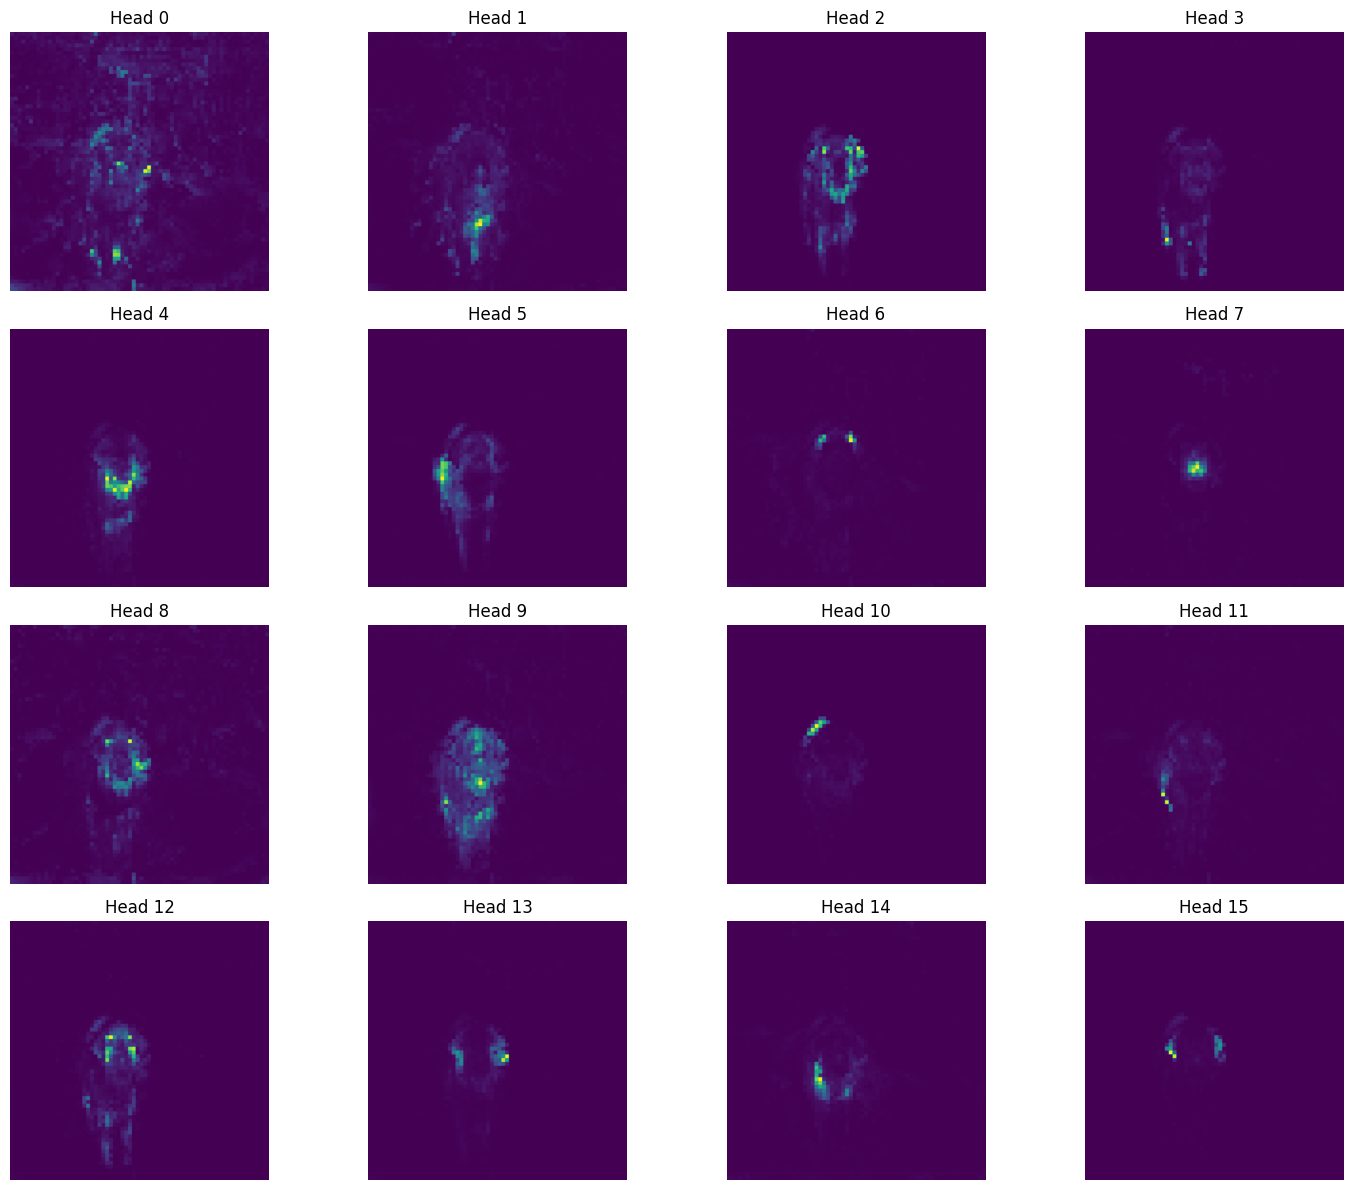

In [9]:

num_cols = 4  
num_rows = (nh + num_cols - 1) // num_cols 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

for j in range(nh):
    row, col = divmod(j, num_cols)  
    ax = axes[row, col]
    ax.imshow(attentions[j], cmap="viridis")
    ax.set_title(f"Head {j}")
    ax.axis("off")

for idx in range(nh, num_rows * num_cols):
    axes[idx // num_cols, idx % num_cols].axis("off")

plt.tight_layout()
plt.show()


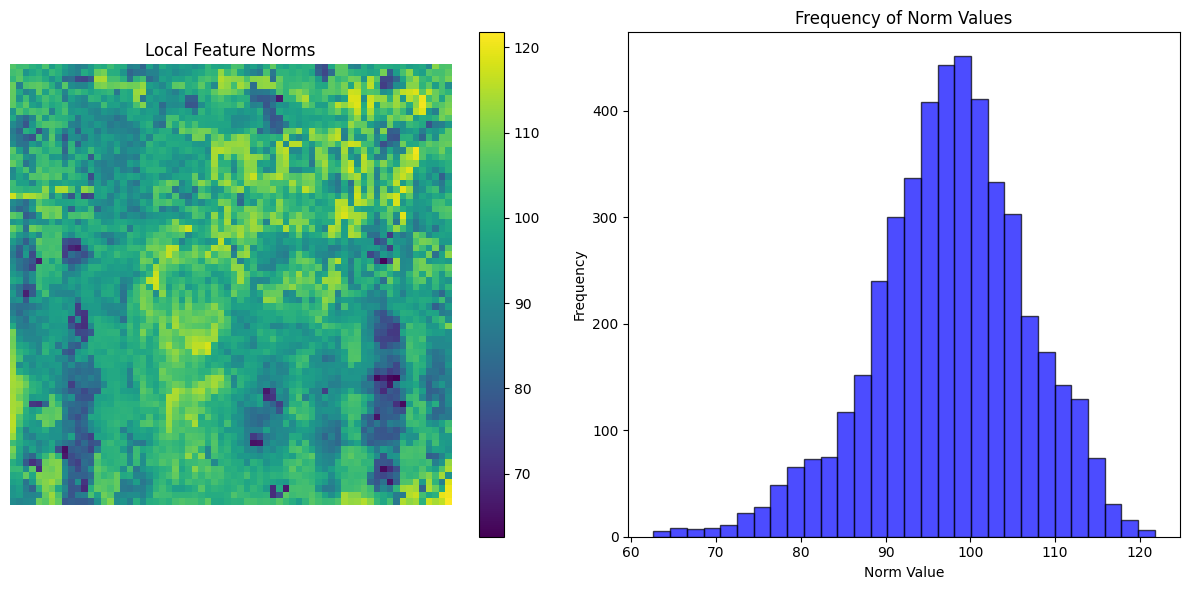

In [11]:
# DINOV2 NORMS WITH REGISTERS

features = model.forward_features(img)["x_prenorm"]
patch_features = features[:, 1:, :]  
local_feature_norms = torch.norm(patch_features, dim=-1)  

w_featmap = h_featmap = int((img.shape[-1] // 14)) 
local_feature_norms = local_feature_norms.reshape(-1, w_featmap, h_featmap)

flattened_norms = local_feature_norms[0].cpu().numpy().flatten()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(local_feature_norms[0].cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Local Feature Norms")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(flattened_norms, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.title("Frequency of Norm Values")
plt.xlabel("Norm Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
